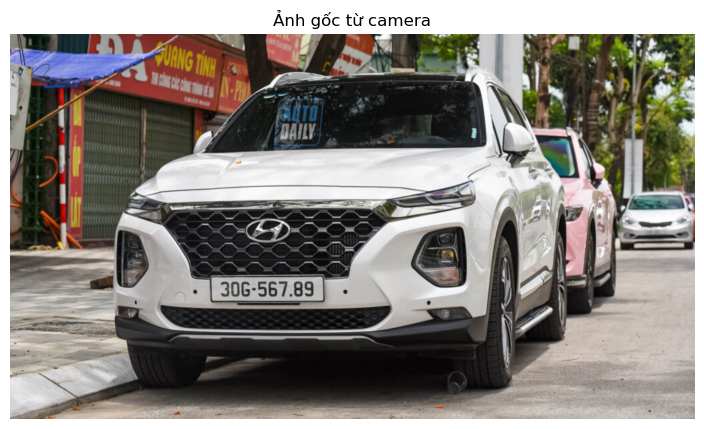

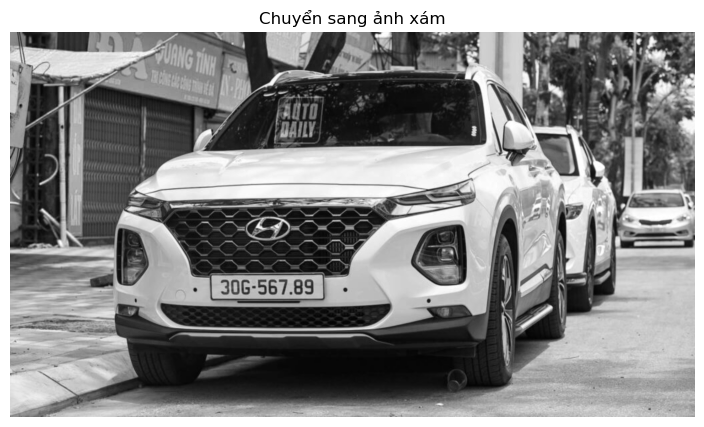

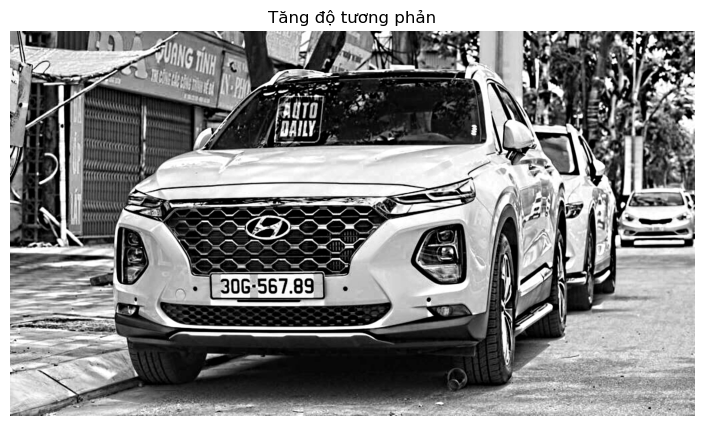

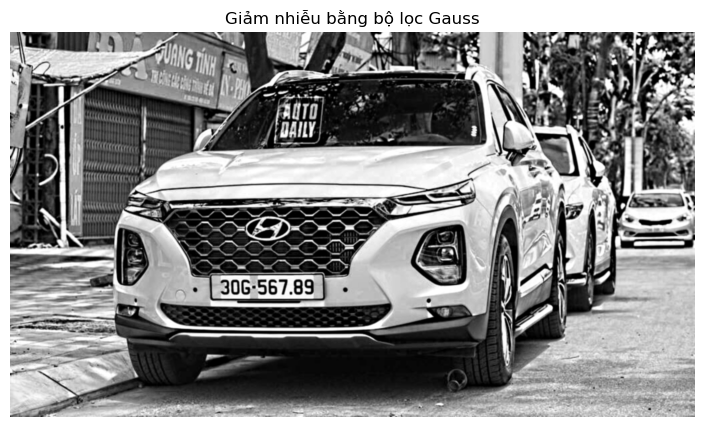

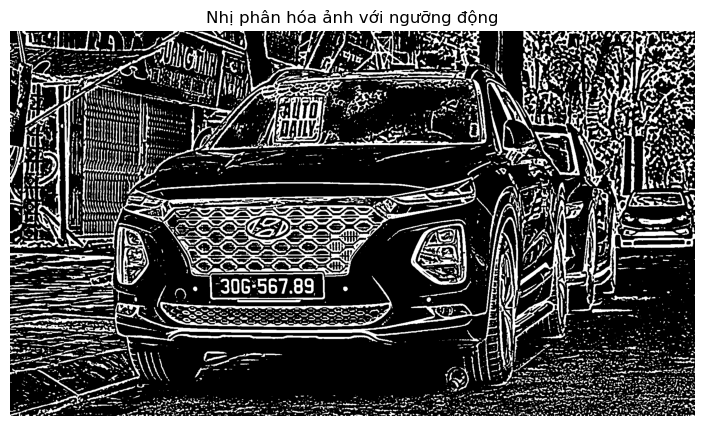

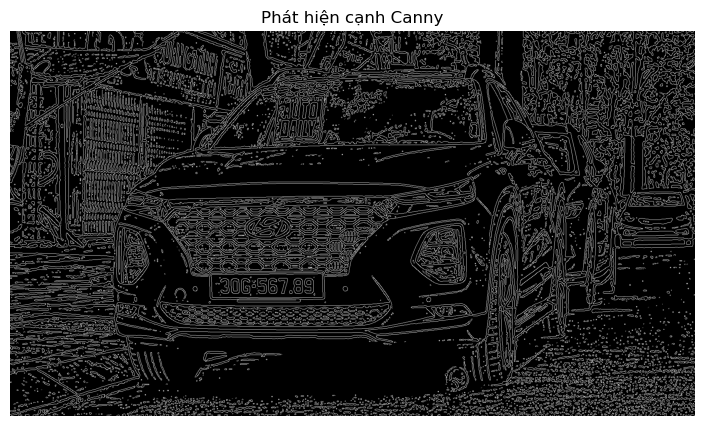

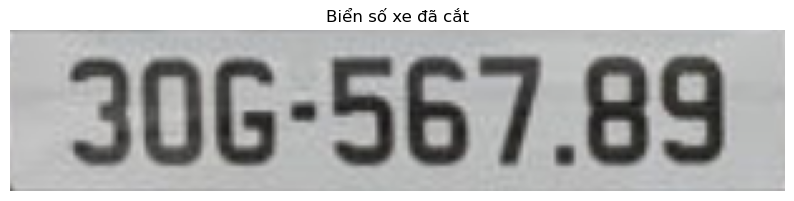

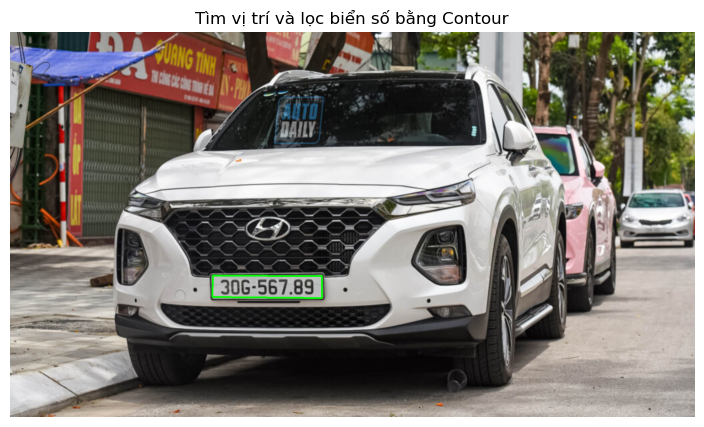

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import Preprocess

# Đọc và thay đổi kích thước hình ảnh
img = cv2.imread("bsx1.jpg")
img = cv2.resize(img, dsize=(1920, 1080))

# Hiển thị ảnh gốc
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc từ camera")
plt.axis('off')
plt.show()

# Chuyển sang ảnh xám
imgGrayscale = Preprocess.extractValue(img)
plt.figure(figsize=(10, 5))
plt.imshow(imgGrayscale, cmap='gray')
plt.title("Chuyển sang ảnh xám")
plt.axis('off')
plt.show()

# Tăng độ tương phản
imgMaxContrastGrayscale = Preprocess.maximizeContrast(imgGrayscale)
plt.figure(figsize=(10, 5))
plt.imshow(imgMaxContrastGrayscale, cmap='gray')
plt.title("Tăng độ tương phản")
plt.axis('off')
plt.show()

# Giảm nhiễu bằng bộ lọc Gauss
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
plt.figure(figsize=(10, 5))
plt.imshow(imgBlurred, cmap='gray')
plt.title("Giảm nhiễu bằng bộ lọc Gauss")
plt.axis('off')
plt.show()

# Nhị phân hóa ảnh với ngưỡng động
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9
imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
plt.figure(figsize=(10, 5))
plt.imshow(imgThresh, cmap='gray')
plt.title("Nhị phân hóa ảnh với ngưỡng động")
plt.axis('off')
plt.show()

# Phát hiện cạnh Canny
canny_image = cv2.Canny(imgThresh, 250, 255)
plt.figure(figsize=(10, 5))
plt.imshow(canny_image, cmap='gray')
plt.title("Phát hiện cạnh Canny")
plt.axis('off')
plt.show()

# Tìm vị trí và lọc biển số bằng Contour
kernel = np.ones((3, 3), np.uint8)
dilated_image = cv2.dilate(canny_image, kernel, iterations=1)

contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

screenCnts = []
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        [x, y, w, h] = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(approx)
        rect_area = w * h
        extent = float(area) / rect_area
        
        # Điều kiện lọc theo tỉ lệ khung hình và diện tích
        if 2 <= aspect_ratio <= 5 and extent > 0.6:  
            screenCnts.append(approx)

if screenCnts:
    # Chỉ lấy contour đầu tiên
    screenCnt = screenCnts[0]
    
    # Cắt vùng biển số xe
    x, y, w, h = cv2.boundingRect(screenCnt)
    license_plate = img[y:y+h, x:x+w]
    
    # Hiển thị biển số xe đã cắt
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
    plt.title("Biển số xe đã cắt")
    plt.axis('off')
    plt.show()

    # Lưu ảnh biển số xe đã cắt
    cv2.imwrite("license_plate.png", license_plate)

    # Vẽ contour lên ảnh gốc
    cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Tìm vị trí và lọc biển số bằng Contour")
    plt.axis('off')
    plt.show()




In [82]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [83]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

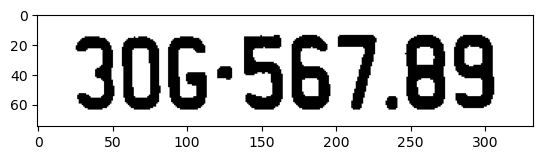

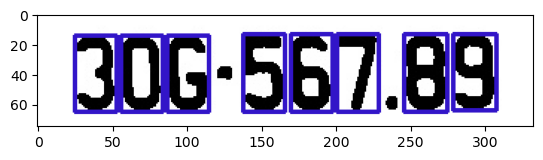

In [84]:
# Let's see the segmented characters
char = segment_characters(license_plate)


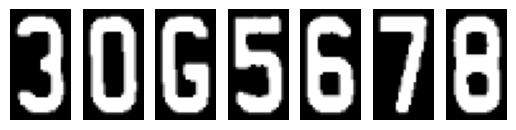

In [85]:
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Detected license plate number: 3DG5B7BB


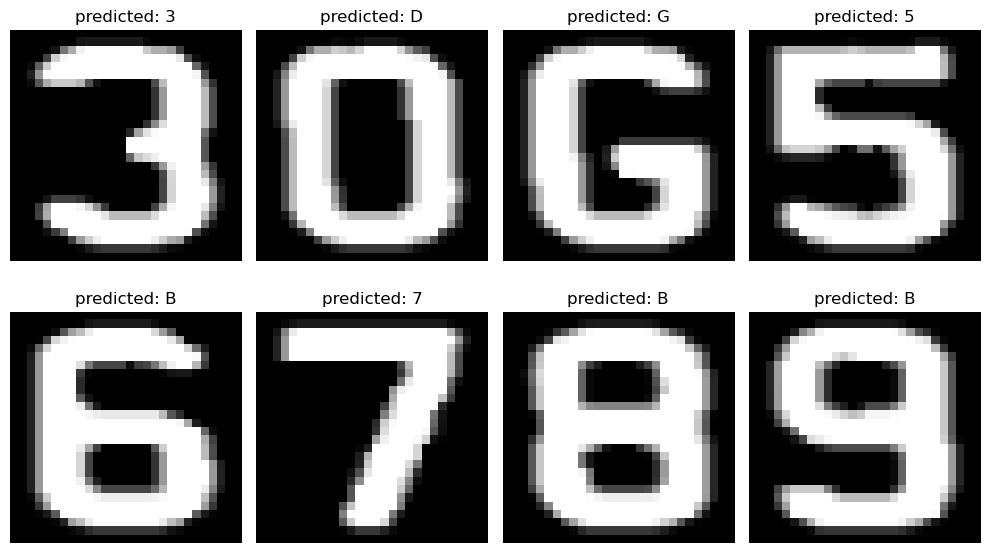

In [86]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Tải mô hình đã lưu
model = load_model('best_model.keras')

# Hàm để sửa đổi kích thước ảnh
def fix_dimension(img): 
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

# Hàm để hiển thị kết quả
def show_results(char_list):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char_list):  # Duyệt qua các ảnh ký tự
        try:
            img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
            img = fix_dimension(img_)
            img = img.reshape(1, 28, 28, 3)  # Chuẩn bị ảnh cho mô hình
            y_ = np.argmax(model.predict(img), axis=-1)[0]  # Dự đoán lớp
            character = dic[y_]  #
            output.append(character)  # Lưu trữ kết quả vào danh sách
        except Exception as e:
            print(f"Error processing character {i}: {e}")
            output.append('?')  # Thêm dấu '?' cho ký tự gây lỗi
        
    plate_number = ''.join(output)
    
    return plate_number, output


# Hiển thị kết quả dự đoán
plate_number, predictions = show_results(char)
print(f"Detected license plate number: {plate_number}")

# Hiển thị từng ký tự với dự đoán
plt.figure(figsize=(10, 6))
for i, ch in enumerate(char):
    img = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
    plt.subplot(2, 4, i+1)  # Hiển thị trên nhiều hàng và cột
    plt.imshow(img, cmap='gray')
    plt.title(f'predicted: {predictions[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()